<div style=float:right><img src="assets/img/applied-logo_100px.png"></img></div>

#### Applied AI Internal Demo Project
## Survival Analysis HDD

Demo some capabilities of parametric and nonparametric survival analysis using Python tools.  
Using hard drive survival data from the [BackBlaze HDD tests](https://www.backblaze.com/blog/hard-drive-data-feb2015/)


# 05_InteractiveAalenModel

+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)


+ [Prepare Data for Modelling](#Prepare-Data-for-Modelling)
    + [Initial Descriptive Analysis](Initial-Descriptive-Analysis)
    
    
+ [Inital Modelling](#Inital-Modelling)
    + [Cross-validate and evaluate concordances](#Cross-validate-and-evaluate-concordances)
    + [View time-varying coeffs](#View-time-varying-coeffs)
    




# Setup

In [1]:
## Interactive magics - comment out if running from another script
%matplotlib inline
%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

In [2]:
from __future__ import division, print_function
from collections import OrderedDict
import sqlite3
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from pandas.tseries.offsets import *
import patsy as pt
import seaborn as sns
from sklearn.cross_validation import StratifiedShuffleSplit
import triangle

import lifelines as sa
from lifelines.utils import concordance_index, k_fold_cross_validation

from IPython.html.widgets import interactive, fixed

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set default styles for plotting via pandas, seaborn and matplotlib
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
sns.set(style='darkgrid')
cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 16, 3

np.random.seed(0)
use_prop_of_full_set = 0.25

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Local Functions

In [3]:
def standardize_fit(s):
    """ calculate and return a dict of fit params 
        for standardizing a series {mean, sd, range} """
    return {'mean': s.mean(), 'sd': s.std(), 'range': s.max() - s.min()}


def standardize_transform(s, center, denominator):
    """ transform series according to center and denominator """
    return (s - center) / denominator


def create_dmatrix_for_modelling(formula, df, predictonly=False):
    """ transform compact dataframe into expanded """
    dft = pt.dmatrix(formula, df, return_type='dataframe')
    design_info = dft.design_info
    
    if predictonly:
        return dft, design_info
    else:
        return dft.join(df[['ndaysduration','failed']]), design_info

    
def plot_concordance(modelspecs, scores):

    fig, axes = plt.subplots(nrows=len(modelspecs), ncols=1, figsize=(18,1.2*len(modelspecs)), squeeze=False, sharex=True)
    fig.suptitle('Concordance evaluation of Aalen survival regression models',fontsize=14)

    for i, (modelnm, _) in enumerate(modelspecs.items()):
        axes[i,0].boxplot(scores[modelnm], vert=False, showmeans=True, meanprops={'marker':'d','mfc':'g','ms':10})
        axes[i,0].annotate(s='{:.3f}'.format(scores[modelnm].mean()), size=12, color='g'
                           ,xy=(scores[modelnm].mean(),1), xycoords='data',xytext=(0,10), textcoords='offset points')
        axes[i,0].axes.grid(True, linestyle='-',color='#AAAAAA')
        axes[i,0].set_title('{}: {}'.format(modelnm,modelspecs[modelnm]))
        axes[i,0].set_xlabel('concordance score')

    plt.subplots_adjust(top=0.9, wspace=0, hspace=1)
    

## Load Data

In [4]:
cnx = sqlite3.connect('data/drive_stats.db')
df = pd.read_sql('select * from drive_survival_prepared', con=cnx
                 ,index_col='diskid', parse_dates=['startdate','enddate'])

In [5]:
print(df.shape)
df.head()

(47226, 14)


,model,startdate,enddate,nrecords,nhoursinservice,failed,ndaysduration,manufacturer,capacity,startdateym,enddateym,startdateyq,enddateyq,meanhoursperdayservice
diskid,,,,,,,,,,,,,,
5XW004AJ,ST31500541AS,2013-04-20,2014-12-31,564,14889,0,620,SEAGATE,1.5TB,201304,201412,201302,201404,24.014516
5XW004Q0,ST31500541AS,2013-04-10,2014-12-31,574,15130,0,630,SEAGATE,1.5TB,201304,201412,201302,201404,24.015873
5XW008MX,ST31500541AS,2013-04-10,2014-12-31,574,15130,0,630,SEAGATE,1.5TB,201304,201412,201302,201404,24.015873
5XW00B95,ST31500541AS,2013-04-10,2014-12-31,574,15129,0,630,SEAGATE,1.5TB,201304,201412,201302,201404,24.014286
5XW00E5M,ST32000542AS,2013-05-16,2014-07-31,386,10578,0,441,SEAGATE,2.0TB,201305,201407,201302,201403,23.986395


In [6]:
df.dtypes

model                             object
startdate                 datetime64[ns]
enddate                   datetime64[ns]
nrecords                           int64
nhoursinservice                    int64
failed                             int64
ndaysduration                    float64
manufacturer                      object
capacity                          object
startdateym                       object
enddateym                         object
startdateyq                       object
enddateyq                         object
meanhoursperdayservice           float64
dtype: object

In [7]:
rightcensor = df['ndaysduration'].max()
rightcensor

630.0

---

# Prepare Data For Modelling

##### Subselect rows for interactive model dev

In [8]:
if (use_prop_of_full_set > 0) & (use_prop_of_full_set < 1):

    kfold_shuffle0 = StratifiedShuffleSplit(y=df['failed'].values, n_iter=1, test_size=(1 - use_prop_of_full_set), random_state=0)

    for retained_idx, removed_idx in kfold_shuffle0:
        dfi = df.iloc[retained_idx].copy()
        break

dfi = dfi.sort_index()    
print(dfi.shape)

(11806, 14)


##### Declare universe of feats available for use

In [9]:
feats_factor = ['manufacturer', 'model', 'capacity', 'startdateyq']
feats_numeric = ['meanhoursperdayservice']
feats_numeric2sd = ['{}2sd'.format(f) for f in feats_numeric]

##### Standardize numeric feats

In [10]:
fits_df, fits_dfi = OrderedDict(), OrderedDict()

for f1, f2 in zip(feats_numeric, feats_numeric2sd):
    ## transform dfr
    fits_df[f1] = standardize_fit(df[f1])
    df[f2] = standardize_transform(df[f1], fits_df[f1]['mean'], 2*fits_df[f1]['sd'])
    ## transform dfi
    fits_dfi[f1] = standardize_fit(dfi[f1])
    dfi[f2] = standardize_transform(dfi[f1], fits_dfi[f1]['mean'], 2*fits_dfi[f1]['sd'])

##### Quick view of numeric feats

In [11]:
# fig = triangle.corner(dfi[feats_numeric2sd].iloc[::1,:], labels=feats_numeric2sd
#         , quantiles=[0.025, 0.5, 0.975], show_titles=True, title_args={"fontsize": 10}
#         , verbose=False, plot_ellipse=True)

---

# Inital Modelling

## Cross-validate and evaluate concordances

### Setup modelspecs

In [12]:
modelspecs, modelspecs_trans, models, scores = OrderedDict(), OrderedDict(), OrderedDict(), OrderedDict()

In [13]:
modelspecs['m0'] = ''    # <- baseline should be 0.5 concordance
modelspecs['m1'] = 'manufacturer'
modelspecs['m2'] = 'model'
modelspecs['m3'] = 'capacity'
modelspecs['m4'] = 'startdateyq'
modelspecs['m5'] = 'meanhoursperdayservice2sd'
modelspecs['m6'] = 'manufacturer + capacity + startdateyq + meanhoursperdayservice2sd'
modelspecs['m7'] = 'manufacturer + model + capacity + startdateyq + meanhoursperdayservice2sd'

### Build and evaluate models (5-fold crossval)

In [14]:
for modelnm, modelspec in modelspecs.items():
    dft, dft_design_info = create_dmatrix_for_modelling(modelspec, dfi)  
    modelspecs_trans[modelnm] = dft.columns.values
    models[modelnm] = sa.AalenAdditiveFitter(fit_intercept=False, coef_penalizer=10, smoothing_penalizer=10)
    scores[modelnm] = np.array(k_fold_cross_validation(models[modelnm], dft, k=5
                        ,duration_col='ndaysduration', event_col='failed' ,predictor='predict_expectation'))


 [-----------------100%-----------------] 561 of 561 complete in 0.4 sec
 [-----------------100%-----------------] 562 of 562 complete in 0.6 sec
 [-----------------100%-----------------] 562 of 562 complete in 0.7 sec
 [-----------------100%-----------------] 562 of 562 complete in 0.5 sec
 [-----------------100%-----------------] 561 of 561 complete in 0.4 sec
 [-----------------100%-----------------] 561 of 561 complete in 0.5 sec
 [-----------------100%-----------------] 562 of 562 complete in 0.5 sec
 [-----------------100%-----------------] 562 of 562 complete in 0.5 sec
 [-----------------100%-----------------] 562 of 562 complete in 0.5 sec
 [-----------------100%-----------------] 561 of 561 complete in 0.5 sec
 [-----------------100%-----------------] 561 of 561 complete in 1.8 sec
 [-----------------100%-----------------] 562 of 562 complete in 1.6 sec
 [-----------------100%-----------------] 562 of 562 complete in 1.5 sec
 [-----------------100%-----------------] 562 of 56

##### View concordance scores

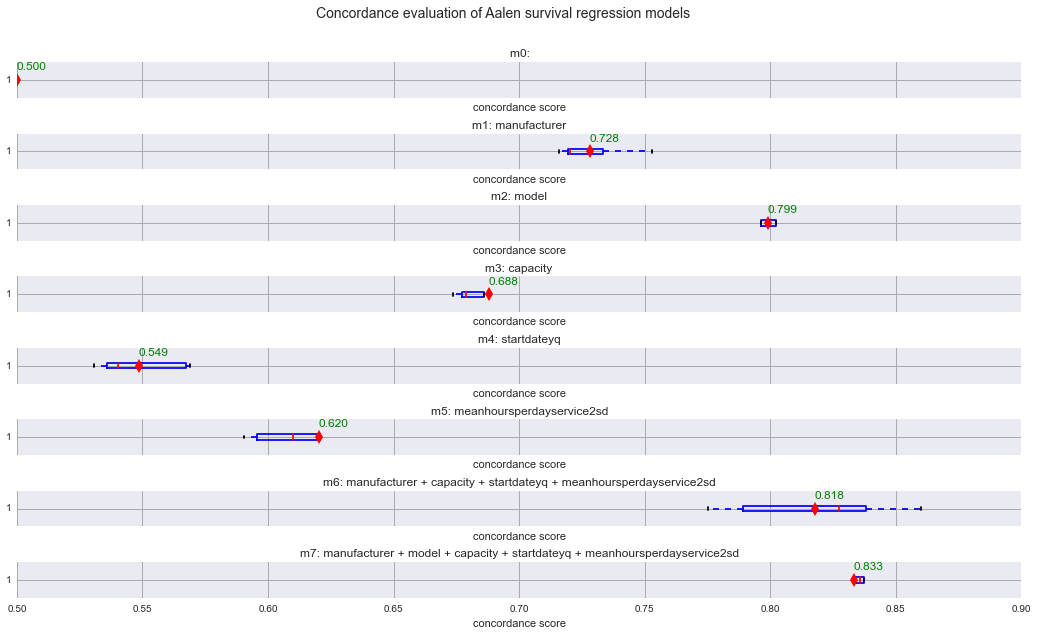

In [15]:
plot_concordance(modelspecs, scores)

**Observe:** The model contains HUGE amount of information pertatining to the survival, however it's not esp useful for later simulation because not independent of manufacturer

### View cumulative hazards and time-varying hazards of modelspec of interest

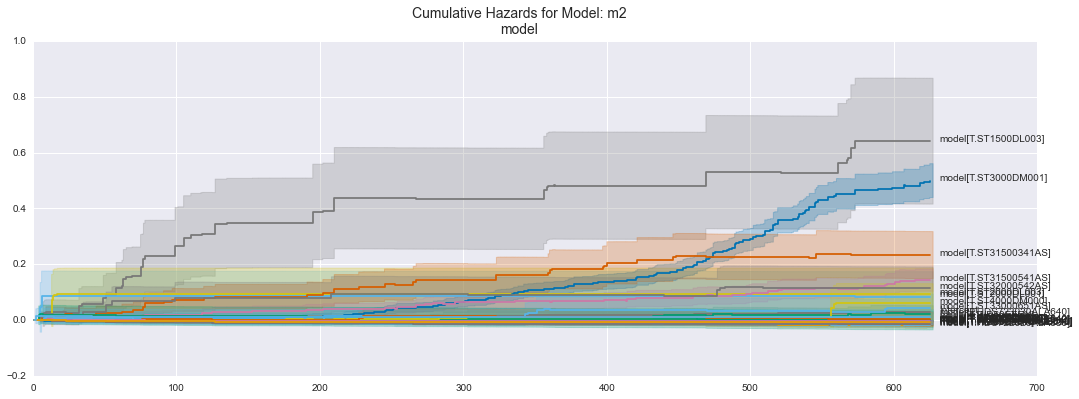

In [16]:
modelnm = 'm2'
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,6), squeeze=False)
fig.suptitle('Cumulative Hazards for Model: {}\n{}'.format(modelnm,modelspecs[modelnm]), fontsize=14)
models[modelnm].plot(ax=axes[0,0], legend=False)
for feat in modelspecs_trans[modelnm][:-2]:
    xpos = models[modelnm].cumulative_hazards_.index[-1]
    ypos = models[modelnm].cumulative_hazards_.iloc[-1][feat]
    axes[0,0].annotate(s=feat, xy=(xpos,ypos), xycoords='data', xytext=(10,0), textcoords='offset points')

In [17]:
# dfrm = pd.rolling_mean(models[modelnm].hazards_,30).stack().reset_index()
# dfrm.columns = ['policymonth','feat','hazardrate']
# ax = sns.lmplot(x='policymonth',y='hazardrate', data=dfrm, hue='feat', col='feat', col_wrap=3
#            ,size=4, aspect=0.9, palette=cmap_clrbld, ci=95, order=1
#            ,scatter_kws={'marker':',', 's':30, 'alpha':0.7, 'linewidths':0.3, 'edgecolor':'#666666'})

---

---

# Train Full Model

## Execute preferred modelspec

In [18]:
prefmodelnm = 'm6'
modelspecs[prefmodelnm]

'manufacturer + capacity + startdateyq + meanhoursperdayservice2sd'

In [19]:
dft, dft_design_info = create_dmatrix_for_modelling(modelspecs[prefmodelnm], df)
singlemodelspecs_trans = dft.columns.values

feat2factormap = OrderedDict()
for feat in modelspecs[prefmodelnm].split(' + '):
    feat2factormap[feat] = ['Intercept']

for nm in singlemodelspecs_trans[1:-2]:
    feat = nm.split('[')[0]
    feat2factormap[feat].append(nm)

In [20]:
model = sa.AalenAdditiveFitter(fit_intercept=False, coef_penalizer=10, smoothing_penalizer=10)
model.fit(dft, duration_col='ndaysduration', event_col='failed')

 [-----------------100%-----------------] 2810 of 2808 complete in 14.1 sec


<lifelines.AalenAdditiveFitter: fitted with 47226 observations, 44418 censored>

### Quick view cumulative hazards

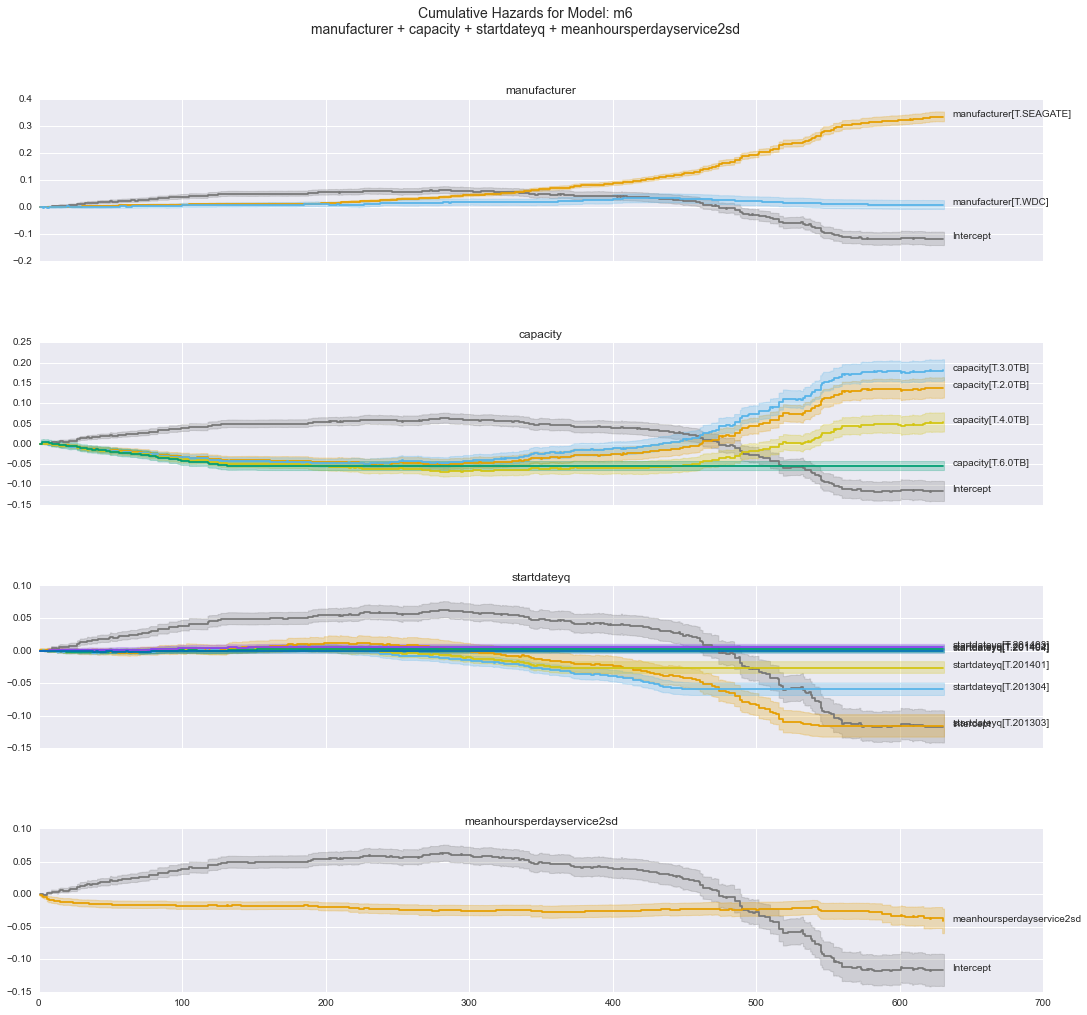

In [21]:
feats = feat2factormap.keys()
fig, axes = plt.subplots(nrows=len(feats), ncols=1, figsize=(18,len(feats)*4), squeeze=False, sharex=True)
fig.suptitle('Cumulative Hazards for Model: {}\n{}'.format(prefmodelnm, modelspecs[prefmodelnm]), fontsize=14)

for i, feat in enumerate(feats):
    ax = model.plot(columns=feat2factormap[feat],ax=axes[i,0], legend=False)
    ax.set_title(feat)
    for factor in feat2factormap[feat]:
        xpos = model.cumulative_hazards_.index[-1]
        ypos = model.cumulative_hazards_.iloc[-1][factor]
        axes[i,0].annotate(s=factor, xy=(xpos,ypos), xycoords='data', xytext=(10,0), textcoords='offset points')

### Output params to DB

##### Hazard coeffs

In [22]:
dfout = model.hazards_.copy()
dfout.rename(columns=lambda x: re.sub('(\[T\.)','_',re.sub('\]','',x)),inplace=True)
dfout.rename(columns=lambda x: re.sub('\%','',x),inplace=True)
dfout.to_sql('{}_hazards'.format(prefmodelnm), con=cnx, if_exists='replace', index_label='ndaysduration')
dfout.describe()

,Intercept,manufacturer_SEAGATE,manufacturer_WDC,capacity_2.0TB,capacity_3.0TB,capacity_4.0TB,capacity_6.0TB,startdateyq_201303,startdateyq_201304,startdateyq_201401,startdateyq_201402,startdateyq_201403,startdateyq_201404,meanhoursperdayservice2sd
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,5.050000e+02,5.050000e+02,5.050000e+02,5.050000e+02,5.050000e+02,5.050000e+02,5.050000e+02,505.000000
mean,-0.000232,0.000661,0.000016,0.000273,0.000359,0.000105,-1.077611e-04,-2.287512e-04,-1.169035e-04,-5.064416e-05,5.378363e-06,1.141049e-05,-1.253533e-07,-0.000082
std,0.001444,0.001390,0.000451,0.001432,0.001614,0.001172,4.626934e-04,8.372105e-04,3.530188e-04,3.055994e-04,1.177122e-04,9.554336e-05,9.257936e-05,0.000469
min,-0.010442,-0.000320,-0.001519,-0.003728,-0.003688,-0.003778,-3.549283e-03,-7.786454e-03,-1.961112e-03,-2.028416e-03,-8.878545e-04,-7.943064e-04,-8.938855e-04,-0.005148
25%,-0.000439,0.000030,-0.000105,-0.000269,-0.000229,-0.000365,-9.187927e-57,-3.731516e-04,-2.158042e-04,-7.304143e-05,4.940656e-324,-1.541759e-119,1.482197e-323,-0.000037
50%,-0.000048,0.000229,-0.000022,0.000053,0.000076,0.000039,-8.176594e-264,-1.018641e-04,-7.819555e-06,1.976263e-322,5.749613e-249,-1.126414e-312,2.341888e-313,0.000011
75%,0.000281,0.000647,0.000043,0.000471,0.000533,0.000387,-1.482197e-323,-1.441826e-37,-9.864723e-283,8.940514e-37,2.328886e-48,-9.881313e-324,1.526697e-111,0.000070
max,0.003757,0.012574,0.003785,0.010318,0.012320,0.007013,3.275042e-03,1.702822e-03,7.722176e-04,1.733339e-03,5.422867e-04,4.958867e-04,5.345854e-04,0.001148


##### Hazard coeff variance

In [23]:
dfout = model.variance_.copy()
dfout.rename(columns=lambda x: re.sub('(\[T\.)','_',re.sub('\]','',x)),inplace=True)
dfout.rename(columns=lambda x: re.sub('\%','',x),inplace=True)
dfout.to_sql('{}_variance'.format(prefmodelnm), con=cnx, if_exists='replace', index_label='ndaysduration')
dfout.head()

,Intercept,manufacturer_SEAGATE,manufacturer_WDC,capacity_2.0TB,capacity_3.0TB,capacity_4.0TB,capacity_6.0TB,startdateyq_201303,startdateyq_201304,startdateyq_201401,startdateyq_201402,startdateyq_201403,startdateyq_201404,meanhoursperdayservice2sd
1,3.057646e-09,1.924201e-09,2.346175e-07,1.247568e-08,8.436553e-09,2.791324e-08,3.010429e-07,1.075763e-06,1.110462e-09,1.487128e-08,1.553830e-08,9.452170e-09,3.223213e-10,9.084583e-07
2,4.431863e-08,3.869886e-08,4.983966e-07,1.506216e-07,2.065555e-08,6.087981e-08,9.011850e-06,3.490752e-08,1.978234e-07,1.161936e-07,5.415171e-08,3.246367e-08,3.746885e-08,7.811835e-07
3,2.026843e-09,3.634221e-09,2.766789e-07,9.338152e-09,6.099297e-09,1.827120e-08,3.017142e-07,3.101909e-09,6.098675e-08,9.360281e-08,1.177978e-08,6.868040e-09,3.663740e-10,8.796531e-07
4,1.719109e-08,2.787168e-08,3.511536e-07,1.403219e-08,5.630633e-09,1.335955e-07,5.001155e-07,1.212959e-07,1.286108e-07,1.771762e-07,9.194350e-08,1.359766e-07,2.312987e-07,4.556331e-07
5,2.211309e-08,2.250397e-08,2.442056e-08,1.588104e-07,6.124429e-09,3.755884e-08,8.812743e-09,3.234500e-08,3.679706e-08,1.635419e-07,4.371183e-08,9.272110e-08,3.973700e-08,1.957446e-09


---

# Interactive Survival Curve Simulation

## Import model coeffs and transformations

In [24]:
# prefmodelnm = 'm6'
modelspecs[prefmodelnm]

'manufacturer + capacity + startdateyq + meanhoursperdayservice2sd'

In [25]:
modelspec_natunits = ['manufacturer','capacity','startdateyq','meanhoursperdayservice']

##### Get hazards and make cumulative

In [26]:
dfhzds = pd.read_sql('select * from {}_hazards'.format(prefmodelnm), con=cnx, index_col='ndaysduration')
dfchzds = dfhzds.cumsum(axis=0)
print(dfchzds.shape)
dfchzds.head()

(505, 14)


,Intercept,manufacturer_SEAGATE,manufacturer_WDC,capacity_2.0TB,capacity_3.0TB,capacity_4.0TB,capacity_6.0TB,startdateyq_201303,startdateyq_201304,startdateyq_201401,startdateyq_201402,startdateyq_201403,startdateyq_201404,meanhoursperdayservice2sd
ndaysduration,,,,,,,,,,,,,,
1,-0.000078,-0.000049,-0.000610,0.000150,0.000123,0.000225,0.000714,0.001474,-0.000046,-0.000163,-0.000163,-0.000128,-0.000021,-0.001211
2,-0.000076,-0.000150,-0.000683,0.000405,0.000184,0.000298,0.003989,0.001492,0.000491,-0.000020,-0.000058,-0.000053,-0.000096,-0.002302
3,-0.000150,-0.000157,-0.001255,0.000535,0.000281,0.000469,0.004606,0.001408,0.000703,0.000296,-0.000168,-0.000133,-0.000110,-0.003254
4,-0.000204,-0.000168,-0.000337,0.000625,0.000378,0.000848,0.003943,0.001112,0.000369,0.000105,-0.000549,-0.000260,-0.000003,-0.003897
5,-0.000393,0.000021,-0.000409,0.001177,0.000474,0.000778,0.003913,0.001178,0.000443,0.000420,-0.000332,0.000201,0.000146,-0.003941


##### Get variances

In [27]:
dfvar = pd.read_sql('select * from {}_variance'.format(prefmodelnm), con=cnx, index_col='ndaysduration')
dfcvar = dfvar.cumsum(axis=0)
print(dfcvar.shape)
dfcvar.head()

(505, 14)


,Intercept,manufacturer_SEAGATE,manufacturer_WDC,capacity_2.0TB,capacity_3.0TB,capacity_4.0TB,capacity_6.0TB,startdateyq_201303,startdateyq_201304,startdateyq_201401,startdateyq_201402,startdateyq_201403,startdateyq_201404,meanhoursperdayservice2sd
ndaysduration,,,,,,,,,,,,,,
1,3.057646e-09,1.924201e-09,0.000000,1.247568e-08,8.436553e-09,2.791324e-08,0.000000,0.000001,1.110462e-09,1.487128e-08,1.553830e-08,9.452170e-09,3.223213e-10,0.000001
2,4.737627e-08,4.062307e-08,0.000001,1.630973e-07,2.909210e-08,8.879304e-08,0.000009,0.000001,1.989338e-07,1.310649e-07,6.969001e-08,4.191584e-08,3.779117e-08,0.000002
3,4.940312e-08,4.425729e-08,0.000001,1.724355e-07,3.519140e-08,1.070642e-07,0.000010,0.000001,2.599206e-07,2.246677e-07,8.146979e-08,4.878388e-08,3.815754e-08,0.000003
4,6.659421e-08,7.212896e-08,0.000001,1.864677e-07,4.082204e-08,2.406597e-07,0.000010,0.000001,3.885314e-07,4.018439e-07,1.734133e-07,1.847605e-07,2.694562e-07,0.000003
5,8.870730e-08,9.463293e-08,0.000001,3.452780e-07,4.694646e-08,2.782186e-07,0.000010,0.000001,4.253284e-07,5.653857e-07,2.171251e-07,2.774816e-07,3.091932e-07,0.000003


## Setup interactive survival curve plot

**NOTE:** Assume that we have dfr, dfchzrds, dfcvar as loaded & prepared above

In [51]:
def create_dfpred_and_plot(**kwargs):

    ## build dfpred
    keys=[]
    for k in kwargs.keys():
        if k in kwargs['modelspec_natunits']:
            keys.append(k)
    
    dfpred = kwargs['dfr'].iloc[:1,:][keys].reset_index()
    del dfpred['diskid']
    dfpred.index = np.array(['simulation'])
    
    for k, v in kwargs.items():
        if k in kwargs['modelspec_natunits']:
            dfpred.ix[0,k] = v
        
    dfpred = pd.concat((kwargs['dfrefline'],dfpred),axis=0)
     
    ## find and transform natural units
    for f in dfpred.columns:
        if f in kwargs['feats_numeric']:
            dfpred['{}2sd'.format(f)] = standardize_transform(dfpred[f], kwargs['fits'][f]['mean'], 2*kwargs['fits'][f]['sd'])   
    
    ## preprare dfpredt
    dfpredtrans = pt.dmatrix(kwargs['dft_design_info'].builder, dfpred, return_type='dataframe')   
    dfpredtrans.rename(columns=lambda x: re.sub('T\.','',x),inplace=True)
    
    dfchzds = kwargs['dfchzds']
    dfcvar = kwargs['dfcvar']  
    
    dfsrv_mean = pd.DataFrame(np.exp(-np.dot(dfpredtrans, dfchzds.T))).cummin(axis=1)
    dfsrv_mean.index = ['reference_survival_curve','simulated_survival_curve']
    
    dfsrv_varpls = pd.DataFrame(np.exp(-np.dot(dfpredtrans, (dfchzds + np.sqrt(dfcvar)).T))).cummin(axis=1)
    dfsrv_varmns = pd.DataFrame(np.exp(-np.dot(dfpredtrans, (dfchzds - np.sqrt(dfcvar)).T))).cummin(axis=1)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,8), squeeze=False)
        
    dfsrv_mean.T.plot(ax=axes[0,0], legend=True)

    plt.fill_between(dfsrv_varpls.T.index.values, dfsrv_varpls.T.iloc[:,0], dfsrv_varmns.T.iloc[:,0]
                     , axes=axes[0,0], alpha=0.2, color=cmap_clrbld[0])
    plt.fill_between(dfsrv_varpls.T.index.values, dfsrv_varpls.T.iloc[:,1], dfsrv_varmns.T.iloc[:,1]
                     , axes=axes[0,0], alpha=0.2, color=cmap_clrbld[1])
    
    axes[0,0].legend(loc='lower left', fontsize=12)
    axes[0,0].set_ylim([0, 1])

## Create midline ref and lists & ranges for interactive feats

In [52]:
## get median of continuous feats
## temp hack to create empty dataframe, revert to normal method when using continuous feats
# dfrefline = pd.DataFrame(dfr[modelspec_natunits].describe().iloc[0,:]).T.reset_index()
# del dfrefline['index']

dfrefline = pd.DataFrame(df[modelspec_natunits].describe().loc['50%']).T.reset_index()
del dfrefline['index']

## get modal average of factor feats
for f in ['manufacturer','capacity','startdateyq']:
    dfrefline[f] = pd.value_counts(df[f]).argmax()
dfrefline.index = np.array(['midpoint_ref'])

## create lists and ranges for interactive feats
feats_fct, feats_num = {}, {}
for feat in feats_factor:
    if feat in modelspec_natunits:
        feats_fct[feat] = list(np.unique(df[feat]))

for feat in feats_numeric:
    if feat in modelspec_natunits:
        feats_num[feat] = list(np.floor([max(df[feat].min(),0),df[feat].max(),5]))
        
print(dfrefline.T)

                       midpoint_ref
meanhoursperdayservice     23.99321
manufacturer                   HGST
capacity                      4.0TB
startdateyq                  201302


## Draw interactive survival plot

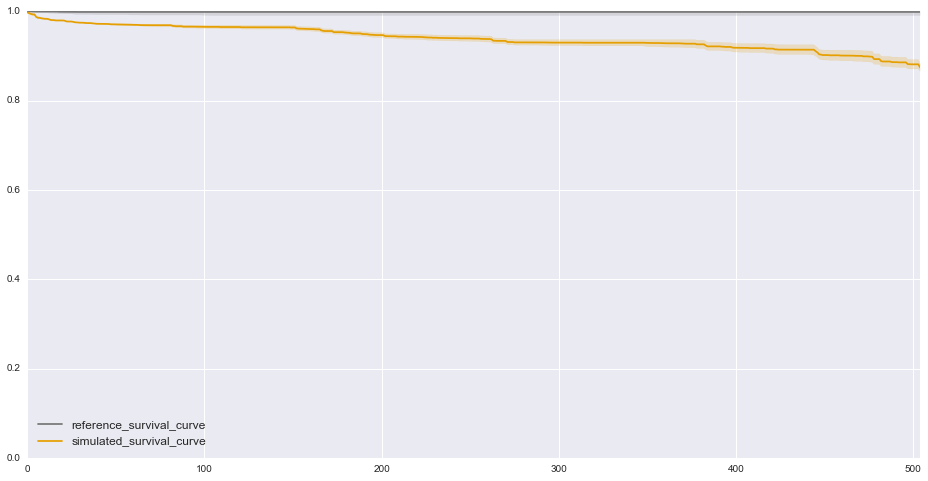

In [53]:
interactive(create_dfpred_and_plot
            ,dfr=fixed(df), dfrefline=fixed(dfrefline), dft_design_info=fixed(dft_design_info)
            ,dfchzds=fixed(dfchzds), dfcvar=fixed(dfcvar)
            ,feats_numeric=fixed(feats_numeric), fits=fixed(fits_df)
            ,modelspec_natunits=fixed(modelspec_natunits)
            ,manufacturer=feats_fct['manufacturer']
            ,capacity=feats_fct['capacity']
            ,startdateyq=feats_fct['startdateyq']
            ,meanhoursperdayservice=tuple(feats_num['meanhoursperdayservice'])
            )

In [47]:
## sanity check
# ax = model.predict_survival_function(dft.iloc[::1000,:]).plot()
# ax.set_ylim([0,1])

---
<div style=float:right><img src=assets/img/applied-logo_100px.png></img></div>
**&copy; Applied AI Ltd 2015**  
<a href='http://www.applied.ai'>applied.ai</a>